In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import fsolve
import math
import numpy.linalg as LA
import sympy as sp
import random

In [2]:
tol = 1e-5

In [3]:
x, y, t1, t2, f1, f2, l, L, d = sp.symbols('x y t1 t2 f1 f2 l L d')
la = 13. # l у основания
lb = 13. # l у основания
lc = 4.25 #L
ld = 4.25 #L
l = la # l у основания
L = lc #L
d = 12.
work_space = []
diff_symb = [x, y, t1, t2, f1, f2]
out_and_pass = [x, y, f1, f2]
in_and_pass = [t1, t2, f1, f2]
func1 = sp.Function('func1')
func2 = sp.Function('func2')
func3 = sp.Function('func3')
func4 = sp.Function('func4')

In [4]:
func1 = x-l*sp.cos(t1)-L*sp.cos(f1)
func2 = x-l*sp.cos(t2)-L*sp.cos(f2)-d
func3 = y-l*sp.sin(t1)-L*sp.sin(f1)
func4 = y-l*sp.sin(t2)-L*sp.sin(f2)
F = [func1, func2, func3, func4]

In [5]:
J_out_and_pass = sp.zeros(len(F),len(out_and_pass))
i=0
j=0
while i < len(F):
    j=0
    while j < len(out_and_pass):
        J_out_and_pass[i,j] = sp.diff(F[i], out_and_pass[j])
        j+=1
    i+=1
J_out_and_pass

Matrix([
[1, 0,  4.25*sin(f1),             0],
[1, 0,             0,  4.25*sin(f2)],
[0, 1, -4.25*cos(f1),             0],
[0, 1,             0, -4.25*cos(f2)]])

In [6]:
J_in_and_pass = sp.zeros(len(F),len(in_and_pass))
i=0
j=0
while i < len(F):
    j=0
    while j < len(in_and_pass):
        J_in_and_pass[i,j] = sp.diff(F[i], in_and_pass[j])
        j+=1
    i+=1
J_in_and_pass

Matrix([
[ 13.0*sin(t1),             0,  4.25*sin(f1),             0],
[            0,  13.0*sin(t2),             0,  4.25*sin(f2)],
[-13.0*cos(t1),             0, -4.25*cos(f1),             0],
[            0, -13.0*cos(t2),             0, -4.25*cos(f2)]])

In [7]:
sp.simplify(J_out_and_pass.det())

-18.0625*sin(f1 - f2)

In [8]:
sp.simplify(J_in_and_pass.det())

3052.5625*sin(f1 - t1)*sin(f2 - t2)

In [9]:
symp_sing1 = sp.simplify(J_in_and_pass.det())
const1 = symp_sing1.func(*[term for term in symp_sing1.args if not term.free_symbols])
symp_sing1 = symp_sing1/const1
sing_f_1 = sp.lambdify(diff_symb, symp_sing1, 'numpy')

symp_sing2 = sp.simplify(J_out_and_pass.det())
const2 = symp_sing2.func(*[term for term in symp_sing2.args if not term.free_symbols])
symp_sing2 = symp_sing2/const2
sing_f_2 = sp.lambdify(diff_symb, symp_sing2, 'numpy')

In [10]:
min_val_cartesian, max_val_cartesian = -16, 16
min_val_revolute, max_val_revolute = -np.pi, np.pi
v1 = np.linspace(min_val_cartesian, max_val_cartesian, int((max_val_cartesian-min_val_cartesian)/2)+1)
# v2 = np.linspace(min_val_revolute, max_val_revolute, int((max_val_revolute-min_val_revolute)/2)+1)
v2 = np.linspace(min_val_revolute, max_val_revolute, 5)

appr = []

for i in v1:
    for j in v1:
        for k in v2:
            for o in v2:
                for m in v2:
                    for p in v2:  
                        appr.append([i,j,k,o,m,p])

In [11]:
v1

array([-16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,
         6.,   8.,  10.,  12.,  14.,  16.])

In [12]:
v2

array([-3.14159265, -1.57079633,  0.        ,  1.57079633,  3.14159265])

In [13]:
len(appr)

180625

In [14]:
2**16

65536

In [15]:
def is_inside(x, y, d):
    D1=(2 * (-1*(x)/(y)) * ( (x)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) ))**2 - 4*(1 + ((x)**2)/(y**2) ) * ( ( (x)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) )**2 - la**2) 
    D2=(2 * (-1*(x-d)/(y)) * ( (x-d)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) ))**2 - 4*(1 + ((x-d)**2)/(y**2) ) * ( ( (x-d)**2/(2*y) + y/2 + (la**2-lc**2)/(2*y) )**2 - la**2)     
    if D1 >= 0 and D2 >= 0:
        work_space.append([x,y])
        return 1
    return 0

In [16]:
def kinematic_eq_sing1(z):
    x = z[0]
    y = z[1]
    t1 = z[2]
    t2 = z[3]
    f1 = z[4]
    f2 = z[5]

    F = np.zeros(6)
    F[0] = (x-l*np.cos(t1)-L*np.cos(f1))
    F[1] = (x-l*np.cos(t2)-L*np.cos(f2)-d)
    F[2] = (y-l*np.sin(t1)-L*np.sin(f1))
    F[3] = (y-l*np.sin(t2)-L*np.sin(f2))
    F[4] = sing_f_1(x,y,t1,t2,f1,f2)
    return F

def kinematic_eq_sing2(z):
    x = z[0]
    y = z[1]
    t1 = z[2]
    t2 = z[3]
    f1 = z[4]
    f2 = z[5]

    F = np.zeros(6)
    F[0] = (x-l*np.cos(t1)-L*np.cos(f1))
    F[1] = (x-l*np.cos(t2)-L*np.cos(f2)-d)
    F[2] = (y-l*np.sin(t1)-L*np.sin(f1))
    F[3] = (y-l*np.sin(t2)-L*np.sin(f2))
    F[4] = sing_f_2(x,y,t1,t2,f1,f2)
    
    return F

Robot work area:


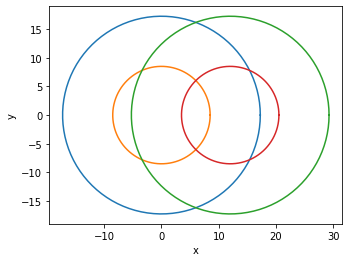

In [17]:
# окружности в питоне легче всего задавать через сферические координаты
# тета меняется от 0 до 2pi
theta = np.linspace(0, 2*np.pi, 100)

x1 = (la+lc)*np.cos(theta)
x2 = (la+lc)*np.sin(theta)
x3 = 2*lc*np.cos(theta)
x4 = 2*lc*np.sin(theta)
x5 = (la+lc)*np.cos(theta)+d
x6 = (la+lc)*np.sin(theta)
x7 = 2*lc*np.cos(theta)+d
x8 = 2*lc*np.sin(theta)

#задаю сетку для расчёта рабочей области
gr_x = np.linspace(-20, 20, 300)
gr_y = np.linspace(-20, 20, 300)
# gr_x = np.linspace(-(la+lc), la+lc+d, 250)
# gr_y = np.linspace(-(la+lc), la+lc+d, 250)
gr_X, gr_Y = np.meshgrid(gr_x,gr_y)
    
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.plot(x3, x4)
ax.plot(x5, x6)
ax.plot(x7, x8)
ax.set_aspect(1)
plt.xlabel('x')
plt.ylabel('y')
print('Robot work area:')
# plt.show()

# plt.scatter(gr_X, gr_Y, color = 'black')
# plt.show()

In [18]:
#функция подсчёта площади
def count_area_new(d_iter):
    S_square=40*40
    number_of_points = len(gr_x)*len(gr_y) #50 000
    number_inside = 0
    for i in range(len(gr_x)):
        for j in range(len(gr_y)):
            number_inside+=is_inside(gr_x[i], gr_y[j], d_iter)
#             is_gran(gr_x[i], gr_y[j], d_iter)
#     S=(S_square*number_inside/number_of_points) # /2 из-за того, что области на графике две, но в реальности она одна
    S = S_square*len(work_space)/number_of_points
    return S

In [19]:
count_area_new(d)

181.79555555555555

Robot work area:


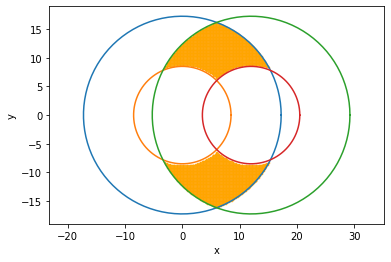

In [20]:
# отрисовка рабочей области
print('Robot work area:')
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.plot(x3, x4)
ax.plot(x5, x6)
ax.plot(x7, x8)
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
# plt.scatter(*zip(*gran), color = 'black')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [21]:
z1 = []
i=0
while i < len(appr):
    zGuess = appr[i]
    x_tmp1 = fsolve(kinematic_eq_sing1, zGuess, xtol=tol)
    f_tmp1 = kinematic_eq_sing1(x_tmp1)
    if np.linalg.norm(np.array(f_tmp1)) < tol:
        z1.append(x_tmp1)
    i+=1

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


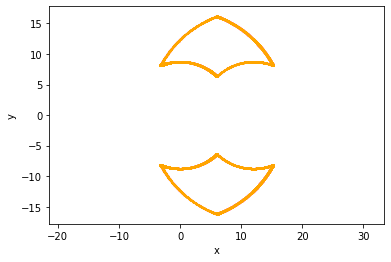

In [22]:
sing_xy1 = []
for i in z1:
    sing_xy1.append([i[0],i[1]])
    
plt.scatter(*zip(*sing_xy1), color = 'orange', s=0.3)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [23]:
z2 = []
i=0
while i < len(appr):
    zGuess = appr[i]
    x_tmp2 = fsolve(kinematic_eq_sing2, zGuess, xtol=tol)
    f_tmp2 = kinematic_eq_sing2(x_tmp2)
    if np.linalg.norm(np.array(f_tmp2)) < tol:
        z2.append(x_tmp2)
    i+=1

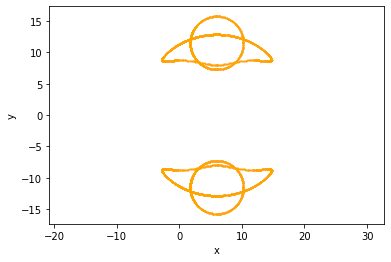

In [24]:
sing_xy2 = []
for i in z2:
    sing_xy2.append([i[0],i[1]])
    
plt.scatter(*zip(*sing_xy2), color = 'orange', s=0.01)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [40]:
xMin = -20
xMax = 20
yMin = -20
yMax = 20
num_squares = 2**12
square_size = abs(xMax-xMin)/np.sqrt(num_squares)
ox = np.linspace(xMin, xMax, np.sqrt(num_squares)+1)
oy = np.linspace(yMin, yMax, np.sqrt(num_squares)+1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [41]:
# sing_xy1_sample = random.sample(sing_xy1, int(round(len(sing_xy1)*0.5,0)))
# sing_xy2_sample = random.sample(sing_xy2, int(round(len(sing_xy2)*0.5,0)))

In [42]:
sing_squares_sing1 = []
sing_squares_sing2 = []

def get_square(p, sing_set):
    i = 0
    while i < len(ox)-1:
        j = 0
        while j < len(oy)-1:
            if p[0] >= ox[i]-tol:
                if p[0] <= ox[i+1] + tol:
                    if p[1] >= oy[j] - tol:
                        if p[1] <= oy[j+1] + tol:
                            sing_set.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])
            j+=1
        i+=1
    return sing_set

for i in sing_xy1:
    get_square(i, sing_squares_sing1)
    
for i in sing_xy2:
    get_square(i, sing_squares_sing2)
    
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

127296
99229


In [43]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

In [44]:
sing_squares_sing1 = Remove(sing_squares_sing1)
sing_squares_sing2 = Remove(sing_squares_sing2)
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

177
247


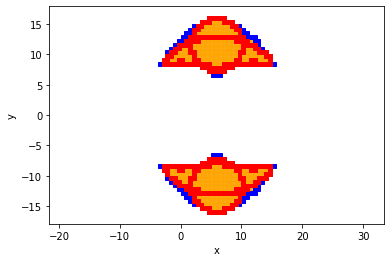

In [45]:
plt.figure()
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 800
# fig_size[1] = 800
# plt.rcParams["figure.figsize"] = fig_size
currentAxis = plt.gca()
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
for i in sing_squares_sing1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Blue'))
for i in sing_squares_sing2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Red'))

currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.show()
fig.set_size_inches(180.5, 100.5)
plt.savefig('foo.png', dpi=5000)

In [25]:
def make_grid_in_box(x, n):
    gr = []
    min_val_cartesian, max_val_cartesian = x[0][0], x[0][1]
    min_val_revolute, max_val_revolute = -np.pi, np.pi
    v1 = np.linspace(min_val_cartesian, max_val_cartesian, n)
    v2 = np.linspace(min_val_revolute, max_val_revolute, n)

    for i in v1:
        for j in v1:
            for k in v2:
                for o in v2:
                    for m in v2:
                        for p in v2:  
                            gr.append([i,j,k,o,m,p])

    return gr
# make_grid_in_box(initial_box, 5)

In [26]:
def just_func(z):
    x = z[0]
    y = z[1]
    t1 = z[2]
    t2 = z[3]
    f1 = z[4]
    f2 = z[5]

    Func = np.zeros(4)
    Func[0] = (x-l*np.cos(t1)-L*np.cos(f1))
    Func[1] = (x-l*np.cos(t2)-L*np.cos(f2)-d)
    Func[2] = (y-l*np.sin(t1)-L*np.sin(f1))
    Func[3] = (y-l*np.sin(t2)-L*np.sin(f2))
    return Func

In [ ]:
xMin = -20
xMax = 20
yMin = -20
yMax = 20
num_squares = 2**8
square_size = abs(xMax-xMin)/np.sqrt(num_squares)
ox = np.linspace(xMin, xMax, np.sqrt(num_squares)+1)
oy = np.linspace(yMin, yMax, np.sqrt(num_squares)+1)

sing_squares_sing1 = []
sing_squares_sing2 = []
ws_new = []


i = 0
l_ox = len(ox)
l_oy = len(oy)

while i < l_ox-1:
    j = 0
    while j < l_oy-1:
        found1 = False
        found2 = False
#         for s1 in sing_xy1:
#             if found1 == True:
#                 break
#             if s1[0] >= ox[i]-tol:
#                 if s1[0] <= ox[i+1] + tol:
#                     if s1[1] >= oy[j] - tol:
#                         if s1[1] <= oy[j+1] + tol:
#                             sing_squares_sing1.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])            
#                             found1 = True
#         for s2 in sing_xy2:
#             if found2 == True:
#                 break
#             if s2[0] >= ox[i]-tol:
#                 if s2[0] <= ox[i+1] + tol:
#                     if s2[1] >= oy[j] - tol:
#                         if s2[1] <= oy[j+1] + tol:
#                             sing_squares_sing2.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])            
#                             found2 = True
#         if is_inside(ox[i]+square_size/2, oy[j]+square_size/2, d) == 1 and found1 == False and found2 == False:
#             ws_new.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])     
        grid = make_grid_in_box([[ox[i], ox[i+1]],   [oy[j], oy[j+1]]], 6)
        ans_arr = []
        for g in grid:
            ans_arr.append(just_func(g))
#         print(ans_arr[0-2])
            
        min1 = ans_arr[0][0]
        min2 = ans_arr[0][1]
        min3 = ans_arr[0][2]
        min4 = ans_arr[0][3]
        max1 = ans_arr[0][0]
        max2 = ans_arr[0][1]
        max3 = ans_arr[0][2]
        max4 = ans_arr[0][3]
       
        for a in ans_arr:
            if a[0] < min1:
                min1 = a[0]
            if a[1] < min2:
                min2 = a[1]
            if a[2] < min3:
                min3 = a[2]            
            if a[3] < min4:
                min4 = a[3]
            if a[0] > max1:
                max1 = a[0]            
            if a[1] > max2:
                max2 = a[1]             
            if a[2] > max3:
                max3 = a[2]               
            if a[3] > max4:
                max4 = a[3]    
                
        if max(min1,min2,min3,min4) <= 0 and min(max1,max2,max3,max4) >= 0:
                ws_new.append([[ox[i], ox[i+1]],   [oy[j], oy[j+1]]])
        j+=1
    i+=1


    
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))
print(len(ws_new))

In [ ]:
# sing_squares_sing1 = Remove(sing_squares_sing1)
# sing_squares_sing2 = Remove(sing_squares_sing2)
# print(len(sing_squares_sing1))
# print(len(sing_squares_sing2))

In [ ]:
plt.figure()
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 800
# fig_size[1] = 800
# plt.rcParams["figure.figsize"] = fig_size
currentAxis = plt.gca()
# plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
for i in sing_squares_sing1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Blue'))
for i in sing_squares_sing2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Red'))
for i in ws_new:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Orange'))

currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# fig.set_size_inches(180.5, 100.5)
# plt.savefig('foo.png', dpi=500)

In [79]:
ws_new[0]

[[-2.5, -1.25], [-10.0, -8.75]]

In [30]:
xMin = -20
xMax = 20
yMin = -20
yMax = 20
num_squares = 2**16
square_size = abs(xMax-xMin)/np.sqrt(num_squares)
ox = np.linspace(xMin, xMax, np.sqrt(num_squares)+1)
oy = np.linspace(yMin, yMax, np.sqrt(num_squares)+1)

sing_squares_sing1 = []
sing_squares_sing2 = []
ws_new_2 = []


i = 0
l_ox = len(ox)
l_oy = len(oy)

while i < l_ox-1:
    j = 0
    while j < l_oy-1:
        found1 = False
        found2 = False
        for s1 in sing_xy1:
            if found1 == True:
                break
            if s1[0] >= ox[i]-tol:
                if s1[0] <= ox[i+1] + tol:
                    if s1[1] >= oy[j] - tol:
                        if s1[1] <= oy[j+1] + tol:
                            sing_squares_sing1.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])            
                            found1 = True
        for s2 in sing_xy2:
            if found2 == True:
                break
            if s2[0] >= ox[i]-tol:
                if s2[0] <= ox[i+1] + tol:
                    if s2[1] >= oy[j] - tol:
                        if s2[1] <= oy[j+1] + tol:
                            sing_squares_sing2.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])            
                            found2 = True
        if is_inside(ox[i]+square_size/2, oy[j]+square_size/2, d) == 1 and found1 == False and found2 == False:
            ws_new_2.append([[ox[i], ox[i+1]],  [oy[j], oy[j+1]]])  
        j+=1
    i+=1


    
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))
print(len(ws_new_2))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


734
989
6392


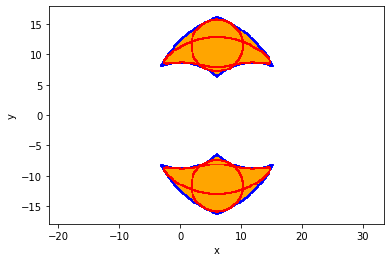

In [36]:
plt.figure()
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 800
# fig_size[1] = 800
# plt.rcParams["figure.figsize"] = fig_size
currentAxis = plt.gca()
# plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
for i in ws_new_2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Orange'))
for i in sing_squares_sing1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Blue'))
for i in sing_squares_sing2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size, alpha=1,color='Red'))

currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.show()
fig.set_size_inches(100, 100)
plt.savefig('foo.png', dpi=500)

In [ ]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [ ]:
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
plt.scatter(*zip(*sing_xy1), color = 'red', s=0.5)
plt.scatter(*zip(*sing_xy2), color = 'blue', s=0.5)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# def make_grid_in_box(x, n):
#     gr = []
# #     gr_x = np.linspace(x[0][0], x[0][1], n)
# #     gr_y = np.linspace(x[1][0], x[1][1], n)
# #     gr_X, gr_Y = np.meshgrid(gr_x,gr_y)
# #     print(gr_X)
# #     print(gr_Y)

#     min_val_cartesian, max_val_cartesian = x[0][0], x[1][1]
#     min_val_revolute, max_val_revulute = -np.pi, np.pi
#     v1 = np.linspace(min_val_cartesian, max_val_cartesian, n)
#     v2 = np.linspace(min_val_revolute, max_val_revulute, n)

#     for i in v1:
#         for j in v1:
#             for k in v2:
#                 for o in v2:
#                     for m in v2:
#                         for p in v2:  
#                             gr.append([i,j,k,o,m,p])

# #     for i in gr_x:
# #         for j in gr_y:
# #             gr.append([i,j])
# #     print(len(gr))
#     return gr
    
# # make_grid_in_box(initial_box, 5)

In [ ]:
# def check_for_proposition(grid, ):
#     minorants = []
#     majorants = []
#     j = 0
#     for i in grid:
#         while j < 4:
#             kinematic_eq_sing1()
#             j+=1

In [ ]:
# initial_box = [[-20, 20], [-20, 20]]
# L = [initial_box]
# A = [] 
# size = 0.1
# L

In [ ]:
# while len(L) > 0:
#     x = L.pop(0)
#     grid = make_grid_in_box(x, 4)
#     i=0
#     while i < len(grid):
#         zGuess = grid[0]
#         x_tmp_gr = fsolve(kinematic_eq_sing1, zGuess, xtol=tol)
#         f_tmp_gr = kinematic_eq_sing1(x_tmp_gr)
#         if np.linalg.norm(np.array(f_tmp_gr)) < tol:
#             if size > x[1][1]-x[0][0]:
#                 A.append(x)
#             else:
#                 L.append([[x[0][0], x[0][1]/2],  [x[1][0], x[1][1]/2]])
# #                 L.append([[x[0][1]/2, x[0][1]],  [x[1][0], x[1][1]/2]])
# #                 L.append([[x[0][1]/2, x[0][1]],  [x[1][1]/2, x[1][1]]])
# #                 L.append([[x[0][0], x[0][1]/2],  [x[1][1]/2, x[1][1]]])
#             break
#         i=0
# A

In [ ]:
def make_center_grid(x, n):
    gr = []
#     min_val_cartesian, max_val_cartesian = x[0], x[0]
    min_val_revolute, max_val_revulute = -np.pi, np.pi
#     v1 = np.linspace(min_val_cartesian, max_val_cartesian, n)
    v2 = np.linspace(min_val_revolute, max_val_revulute, n)


    for k in v2:
        for o in v2:
            for m in v2:
                for p in v2:  
                    gr.append([x[0], x[1],k,o,m,p])

#     for i in gr_x:
#         for j in gr_y:
#             gr.append([i,j])
#     print(len(gr))
    return gr
len(make_center_grid([1,3], 2))

In [ ]:
xMin = -20
xMax = 20
yMin = -20
yMax = 20
num_squares = 2**16
square_size = abs(xMax-xMin)/np.sqrt(num_squares)
ox = np.linspace(xMin, xMax, np.sqrt(num_squares)+1)
oy = np.linspace(yMin, yMax, np.sqrt(num_squares)+1)

In [ ]:
sp_grid = []
i=0
while i < len(ox)-1:
    j = 0
    while j < len(oy)-1:
        sp_grid.append([[ox[i], ox[i+1]],   [oy[j], oy[j+1]]])
        j+=1
    i+=1
# sp_grid


ws_1 = []
sing_1_test = []
for i in sp_grid:
    center_x = i[0][0] + square_size/2
    center_y = i[1][0] + square_size/2
    if (is_inside(center_x, center_y, d)):
        ws_1.append(i)
    center_gr = []
    center_gr = make_center_grid([center_x, center_y], 2)
    j=0
    while j < len(center_gr):
        zGuess = center_gr[j]
        x_tmp3 = fsolve(kinematic_eq_sing1, zGuess, xtol=tol)
        f_tmp3 = kinematic_eq_sing1(x_tmp3)
        if np.linalg.norm(np.array(f_tmp3)) < tol:
            if abs(x_tmp3[0] - (i[0][0] + square_size/2)) < square_size/2 and abs(x_tmp3[1] - (i[1][0] + square_size/2)) < square_size/2:
                sing_1_test.append(i)
        j+=1
    
# ws_1

In [ ]:
plt.figure()
currentAxis = plt.gca()
for i in ws_1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY),  square_size,  square_size, alpha=1,color='Blue'))
for i in sing_1_test:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY),  square_size,  square_size, alpha=1,color='Red'))
currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
sing_squares_sing1 = []
sing_squares_sing2 = []

def get_square(p, sing_set):
    i = 0
    while i < len(ox)-1:
        j = 0
        while j < len(oy)-1:
            if p[0] >= ox[i]:
                if p[0] <= ox[i+1]:
                    if p[1] >= oy[j]:
                        if p[1] <= oy[j+1]:
                            sing_set.append([[ox[i],ox[i+1]],[oy[j],oy[j+1]]])
            j+=1
        i+=1
    return sing_set

for i in sing_xy1:
    get_square(i, sing_squares_sing1)
    
for i in sing_xy2:
    get_square(i, sing_squares_sing2)
    
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

In [ ]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

sing_squares_sing1 = Remove(sing_squares_sing1)
sing_squares_sing2 = Remove(sing_squares_sing2)
print(len(sing_squares_sing1))
print(len(sing_squares_sing2))

In [ ]:
plt.figure()
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 800
# fig_size[1] = 800
# plt.rcParams["figure.figsize"] = fig_size
currentAxis = plt.gca()
plt.scatter(*zip(*work_space), color = 'orange', s=0.2)
for i in sing_squares_sing1:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size,alpha=1,color='Blue'))
for i in sing_squares_sing2:
    someX, someY = i[0][0], i[1][0]
    currentAxis.add_patch(Rectangle((someX, someY), square_size, square_size,alpha=1,color='Red'))

currentAxis.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()